# Music Genre Classification using Spectrogram Images
## CNN + LSTM + Temporal Attention Architecture

This notebook implements two deep learning models for classifying music genres using Mel spectrogram images from the GTZAN dataset:

- **Model A**: Custom CNN + LSTM + Temporal Attention
- **Model B**: EfficientNet-B0 (Transfer Learning) + LSTM + Temporal Attention

## 1. Setup and Imports

First, we import all necessary libraries. We use TensorFlow/Keras for building and training models.

In [1]:
# Standard library imports
import os
import hashlib
import warnings
from collections import defaultdict

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# GPU MEMORY MANAGEMENT - Prevent kernel crashes
# =============================================================================
# Allow GPU memory growth instead of allocating all memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU memory growth setting failed: {e}")

print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


GPU memory growth enabled for 1 GPU(s)
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.0


In [2]:
# =============================================================================
# CONFIGURATION - Adjust this path to match your dataset location
# =============================================================================
# The dataset should have the structure:
# DATASET_ROOT/
#     images_original/
#         blues/
#         classical/
#         ...etc

DATASET_ROOT = "Data"  # Change this if your data is elsewhere
IMAGES_DIR = os.path.join(DATASET_ROOT, "images_original")

# Model hyperparameters - IMPROVED for better accuracy
IMG_HEIGHT = 128      # Height of resized spectrogram (frequency axis)
IMG_WIDTH = 256       # Width of resized spectrogram (time axis)
BATCH_SIZE = 16       # Batch size for training
EPOCHS = 500          # Increased epochs for better convergence
LABEL_SMOOTHING = 0.1 # Label smoothing to prevent overconfident predictions

# Mixup augmentation parameter
MIXUP_ALPHA = 0.2     # Mixup interpolation strength

# Genre classes (10 genres in GTZAN)
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)

print(f"Dataset root: {DATASET_ROOT}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Label smoothing: {LABEL_SMOOTHING}")
print(f"Mixup alpha: {MIXUP_ALPHA}")

Dataset root: Data
Images directory: Data\images_original
Image size: 128x256
Number of classes: 10
Label smoothing: 0.1
Mixup alpha: 0.2


## 2. Data Understanding

### 2.1 Dataset Overview

The **GTZAN Music Genre Dataset** is a widely-used benchmark for music genre classification:

- **10 genres**: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
- **100 audio files per genre** (1000 total)
- **30 seconds each** at 22050 Hz sample rate

The `images_original` folder contains **Mel spectrogram images** generated from the audio files:
- **X-axis (horizontal)**: Time (left to right = start to end of 30-second clip)
- **Y-axis (vertical)**: Frequency (bottom to top = low to high frequencies)
- **Color intensity**: Magnitude/power at that time-frequency point

### 2.2 Known GTZAN Issues

1. **Duplicate/near-duplicate tracks**: Some tracks are repeated or have excerpts from the same song
2. **Potential data leakage**: If duplicates end up in different splits (train/test), we get artificially inflated accuracy
3. **Label noise**: A few tracks may be mislabeled

**Our mitigation strategy**: We will hash image contents to detect exact duplicates and ensure all duplicates stay in the same split.

In [3]:
# -----------------------------------------------------------------------------
# 2.3 Explore the dataset structure
# -----------------------------------------------------------------------------

# Count samples per genre
print("Samples per genre:")
print("-" * 30)
total_samples = 0

for genre in GENRES:
    genre_path = os.path.join(IMAGES_DIR, genre)
    if os.path.exists(genre_path):
        count = len([f for f in os.listdir(genre_path) if f.endswith('.png')])
        print(f"{genre:12s}: {count} images")
        total_samples += count
    else:
        print(f"{genre:12s}: FOLDER NOT FOUND!")

print("-" * 30)
print(f"Total samples: {total_samples}")

Samples per genre:
------------------------------
blues       : 100 images
classical   : 100 images
country     : 100 images
disco       : 100 images
hiphop      : 100 images
jazz        : 99 images
metal       : 100 images
pop         : 100 images
reggae      : 100 images
rock        : 100 images
------------------------------
Total samples: 999


Sample image analysis:
  File: blues00000.png
  Original shape: (288, 432, 3)
    - Height (frequency axis): 288 pixels
    - Width (time axis): 432 pixels
    - Channels: 3
  Pixel value range: [0.0, 255.0]
  Data type: float32


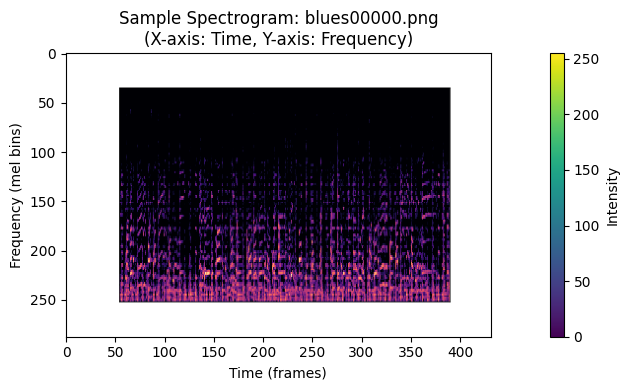

In [4]:
# -----------------------------------------------------------------------------
# 2.4 Examine a sample spectrogram image
# -----------------------------------------------------------------------------

# Load one example image to understand its properties
sample_genre = "blues"
sample_path = os.path.join(IMAGES_DIR, sample_genre)
sample_files = [f for f in os.listdir(sample_path) if f.endswith('.png')]
sample_image_path = os.path.join(sample_path, sample_files[0])

# Load using PIL/Keras to see original dimensions
sample_image = keras.utils.load_img(sample_image_path)
sample_array = keras.utils.img_to_array(sample_image)

print("Sample image analysis:")
print(f"  File: {sample_files[0]}")
print(f"  Original shape: {sample_array.shape}")
print(f"    - Height (frequency axis): {sample_array.shape[0]} pixels")
print(f"    - Width (time axis): {sample_array.shape[1]} pixels")
print(f"    - Channels: {sample_array.shape[2]}")
print(f"  Pixel value range: [{sample_array.min():.1f}, {sample_array.max():.1f}]")
print(f"  Data type: {sample_array.dtype}")

# Display the spectrogram
plt.figure(figsize=(12, 4))
plt.imshow(sample_array.astype('uint8'))
plt.title(f"Sample Spectrogram: {sample_files[0]}\n(X-axis: Time, Y-axis: Frequency)")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (mel bins)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

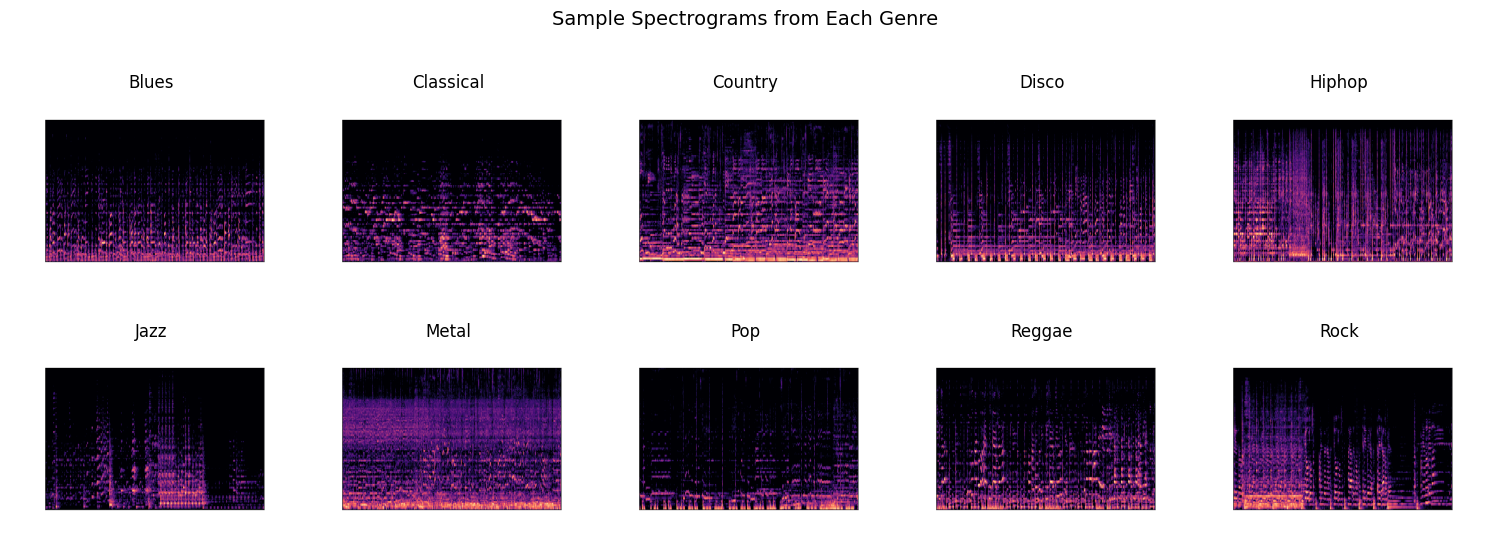

In [5]:
# -----------------------------------------------------------------------------
# 2.5 Display example spectrograms from each genre
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, genre in enumerate(GENRES):
    genre_path = os.path.join(IMAGES_DIR, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.png')]
    img_path = os.path.join(genre_path, files[0])
    
    img = keras.utils.load_img(img_path)
    img_array = keras.utils.img_to_array(img)
    
    axes[idx].imshow(img_array.astype('uint8'))
    axes[idx].set_title(genre.capitalize())
    axes[idx].axis('off')

plt.suptitle("Sample Spectrograms from Each Genre", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Data Loading and Preprocessing

### 3.1 Duplicate Detection and Safe Splitting

To prevent data leakage, we:
1. Hash each image file to detect exact duplicates
2. Group duplicates together
3. Split by groups (not individual files) so duplicates stay in the same split
4. Use stratified splitting to maintain genre balance

In [6]:
# -----------------------------------------------------------------------------
# 3.2 Collect all image paths and detect duplicates using file hashing
# -----------------------------------------------------------------------------

def compute_file_hash(filepath):
    """Compute MD5 hash of a file to detect duplicates."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        # Read in chunks to handle large files efficiently
        for chunk in iter(lambda: f.read(8192), b''):
            hasher.update(chunk)
    return hasher.hexdigest()

# Collect all image paths, labels, and hashes
all_paths = []
all_labels = []
all_hashes = []

print("Scanning images and computing hashes for duplicate detection...")

for genre_idx, genre in enumerate(GENRES):
    genre_path = os.path.join(IMAGES_DIR, genre)
    files = sorted([f for f in os.listdir(genre_path) if f.endswith('.png')])
    
    for filename in files:
        filepath = os.path.join(genre_path, filename)
        file_hash = compute_file_hash(filepath)
        
        all_paths.append(filepath)
        all_labels.append(genre_idx)
        all_hashes.append(file_hash)

# Create a DataFrame for easier manipulation
data_df = pd.DataFrame({
    'path': all_paths,
    'label': all_labels,
    'hash': all_hashes
})

print(f"Total images found: {len(data_df)}")

# Check for duplicates
hash_counts = data_df['hash'].value_counts()
duplicates = hash_counts[hash_counts > 1]

if len(duplicates) > 0:
    print(f"\nFound {len(duplicates)} duplicate groups ({duplicates.sum()} total duplicate files)")
    print("Duplicates will be kept in the same split to prevent data leakage.")
else:
    print("\nNo exact duplicate images found.")

data_df.head(10)

Scanning images and computing hashes for duplicate detection...
Total images found: 999

Found 14 duplicate groups (28 total duplicate files)
Duplicates will be kept in the same split to prevent data leakage.


,path,label,hash
0,Data\images_original\blues\blues00000.png,0,06a1a42403b7ab93357ada99940811d3
1,Data\images_original\blues\blues00001.png,0,08d9bbe72ee679798bcd7f0a973e46e5
2,Data\images_original\blues\blues00002.png,0,176a8a491ccbd8dc53514421100a344c
3,Data\images_original\blues\blues00003.png,0,a050628a7c422890d3832eec83191cec
4,Data\images_original\blues\blues00004.png,0,ad380e774747720e3c773c1f1a846894
5,Data\images_original\blues\blues00005.png,0,82f657bfa1d027ae9fcc9e38996c5708
6,Data\images_original\blues\blues00006.png,0,79ca9cab6a6eee170eeb823407581df1
7,Data\images_original\blues\blues00007.png,0,122e5c0db3bdcf8ebaee9b3215868e4a
8,Data\images_original\blues\blues00008.png,0,d6b9a2a22ee8ba28c0a770d8150d2253
9,Data\images_original\blues\blues00009.png,0,85019b2042325418281637ef4d51cef0


In [7]:
# -----------------------------------------------------------------------------
# 3.3 Create train/validation/test split (70/15/15) with no data leakage
# -----------------------------------------------------------------------------
# Strategy: Group by hash, then split groups to ensure duplicates stay together

def safe_split_data(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split data ensuring files with the same hash stay in the same split.
    This prevents data leakage from duplicate/near-duplicate images.
    """
    # Create group IDs based on hash
    # Each unique hash gets a unique group ID
    unique_hashes = df['hash'].unique()
    hash_to_group = {h: i for i, h in enumerate(unique_hashes)}
    df['group_id'] = df['hash'].map(hash_to_group)
    
    # Get unique groups with their labels (use first occurrence's label for each group)
    groups = df.groupby('group_id').first().reset_index()[['group_id', 'label']]
    
    # First split: separate test set
    groups_train_val, groups_test = train_test_split(
        groups, test_size=test_ratio, stratify=groups['label'], random_state=random_state
    )
    
    # Second split: separate train and validation from remaining
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    groups_train, groups_val = train_test_split(
        groups_train_val, test_size=val_ratio_adjusted, 
        stratify=groups_train_val['label'], random_state=random_state
    )
    
    # Map back to original data
    train_groups = set(groups_train['group_id'])
    val_groups = set(groups_val['group_id'])
    test_groups = set(groups_test['group_id'])
    
    train_df = df[df['group_id'].isin(train_groups)].copy()
    val_df = df[df['group_id'].isin(val_groups)].copy()
    test_df = df[df['group_id'].isin(test_groups)].copy()
    
    return train_df, val_df, test_df

# Perform the split
train_df, val_df, test_df = safe_split_data(data_df)

print("Dataset split (with duplicate-safe grouping):")
print(f"  Training:   {len(train_df):4d} samples ({len(train_df)/len(data_df)*100:.1f}%)")
print(f"  Validation: {len(val_df):4d} samples ({len(val_df)/len(data_df)*100:.1f}%)")
print(f"  Test:       {len(test_df):4d} samples ({len(test_df)/len(data_df)*100:.1f}%)")
print(f"  Total:      {len(data_df):4d} samples")

# Verify no hash overlap between splits (data leakage check)
train_hashes = set(train_df['hash'])
val_hashes = set(val_df['hash'])
test_hashes = set(test_df['hash'])

assert len(train_hashes & val_hashes) == 0, "Leakage between train and val!"
assert len(train_hashes & test_hashes) == 0, "Leakage between train and test!"
assert len(val_hashes & test_hashes) == 0, "Leakage between val and test!"
print("\nNo data leakage detected - all splits have unique content.")

Dataset split (with duplicate-safe grouping):
  Training:    699 samples (70.0%)
  Validation:  150 samples (15.0%)
  Test:        150 samples (15.0%)
  Total:       999 samples

No data leakage detected - all splits have unique content.


In [8]:
# -----------------------------------------------------------------------------
# 3.4 Verify class distribution in each split
# -----------------------------------------------------------------------------

def print_class_distribution(df, split_name):
    """Print the distribution of classes in a split."""
    counts = df['label'].value_counts().sort_index()
    print(f"\n{split_name} class distribution:")
    for idx, count in counts.items():
        print(f"  {GENRES[idx]:12s}: {count:3d}")

print_class_distribution(train_df, "Training")
print_class_distribution(val_df, "Validation")
print_class_distribution(test_df, "Test")


Training class distribution:
  blues       :  70
  classical   :  70
  country     :  70
  disco       :  70
  hiphop      :  70
  jazz        :  69
  metal       :  69
  pop         :  71
  reggae      :  70
  rock        :  70

Validation class distribution:
  blues       :  15
  classical   :  15
  country     :  15
  disco       :  15
  hiphop      :  14
  jazz        :  15
  metal       :  16
  pop         :  15
  reggae      :  15
  rock        :  15

Test class distribution:
  blues       :  15
  classical   :  15
  country     :  15
  disco       :  15
  hiphop      :  16
  jazz        :  15
  metal       :  15
  pop         :  14
  reggae      :  15
  rock        :  15


In [9]:
# -----------------------------------------------------------------------------
# 3.5 Create tf.data datasets with BALANCED DATA AUGMENTATION
# -----------------------------------------------------------------------------

# =============================================================================
# BALANCED DATA AUGMENTATION - Not too aggressive to preserve accuracy
# =============================================================================
def augment_image(image):
    """
    Apply balanced data augmentation to spectrogram images.
    Less aggressive to maintain accuracy while preventing overfitting.
    """
    # Random brightness adjustment (moderate)
    image = tf.image.random_brightness(image, max_delta=0.15)
    
    # Random contrast adjustment (moderate range)
    image = tf.image.random_contrast(image, lower=0.85, upper=1.15)
    
    # Random horizontal flip (time reversal - genre characteristics remain)
    image = tf.image.random_flip_left_right(image)
    
    # SpecAugment-style Time masking (single mask, lower probability)
    if tf.random.uniform([]) > 0.5:  # 50% chance
        img_width = tf.shape(image)[1]
        mask_width = tf.cast(tf.cast(img_width, tf.float32) * tf.random.uniform([], 0.02, 0.08), tf.int32)
        mask_width = tf.maximum(mask_width, 1)
        mask_start = tf.random.uniform([], 0, tf.maximum(img_width - mask_width, 1), dtype=tf.int32)
        
        mask = tf.concat([
            tf.ones([tf.shape(image)[0], mask_start, 3]),
            tf.zeros([tf.shape(image)[0], mask_width, 3]),
            tf.ones([tf.shape(image)[0], img_width - mask_start - mask_width, 3])
        ], axis=1)
        image = image * mask
    
    # SpecAugment-style Frequency masking (single mask, lower probability)
    if tf.random.uniform([]) > 0.5:  # 50% chance
        img_height = tf.shape(image)[0]
        mask_height = tf.cast(tf.cast(img_height, tf.float32) * tf.random.uniform([], 0.02, 0.08), tf.int32)
        mask_height = tf.maximum(mask_height, 1)
        mask_start = tf.random.uniform([], 0, tf.maximum(img_height - mask_height, 1), dtype=tf.int32)
        
        mask = tf.concat([
            tf.ones([mask_start, tf.shape(image)[1], 3]),
            tf.zeros([mask_height, tf.shape(image)[1], 3]),
            tf.ones([img_height - mask_start - mask_height, tf.shape(image)[1], 3])
        ], axis=0)
        image = image * mask
    
    # Ensure values stay in valid range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image

def augment_image_efficientnet(image):
    """
    Apply balanced data augmentation for EfficientNet (values in 0-255 range).
    """
    # Normalize to 0-1 for augmentation
    image = image / 255.0
    
    # Apply same augmentations (moderate)
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, lower=0.85, upper=1.15)
    image = tf.image.random_flip_left_right(image)
    
    # Single time mask
    if tf.random.uniform([]) > 0.5:
        img_width = tf.shape(image)[1]
        mask_width = tf.cast(tf.cast(img_width, tf.float32) * tf.random.uniform([], 0.02, 0.08), tf.int32)
        mask_width = tf.maximum(mask_width, 1)
        mask_start = tf.random.uniform([], 0, tf.maximum(img_width - mask_width, 1), dtype=tf.int32)
        mask = tf.concat([
            tf.ones([tf.shape(image)[0], mask_start, 3]),
            tf.zeros([tf.shape(image)[0], mask_width, 3]),
            tf.ones([tf.shape(image)[0], img_width - mask_start - mask_width, 3])
        ], axis=1)
        image = image * mask
    
    # Single frequency mask
    if tf.random.uniform([]) > 0.5:
        img_height = tf.shape(image)[0]
        mask_height = tf.cast(tf.cast(img_height, tf.float32) * tf.random.uniform([], 0.02, 0.08), tf.int32)
        mask_height = tf.maximum(mask_height, 1)
        mask_start = tf.random.uniform([], 0, tf.maximum(img_height - mask_height, 1), dtype=tf.int32)
        mask = tf.concat([
            tf.ones([mask_start, tf.shape(image)[1], 3]),
            tf.zeros([mask_height, tf.shape(image)[1], 3]),
            tf.ones([img_height - mask_start - mask_height, tf.shape(image)[1], 3])
        ], axis=0)
        image = image * mask
    
    # Clip and convert back to 0-255
    image = tf.clip_by_value(image, 0.0, 1.0) * 255.0
    
    return image

def load_and_preprocess_image(path, label, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load an image, resize it, and normalize pixel values to [0, 1].
    This is for the custom CNN model (Model A).
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image, label

def load_and_preprocess_image_efficientnet(path, label, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load and preprocess image for EfficientNet (Model B).
    EfficientNet expects pixel values in [0, 255] and applies its own preprocessing.
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    return image, label

def create_dataset(df, preprocess_fn, batch_size=BATCH_SIZE, shuffle=True, augment=False, 
                   is_efficientnet=False):
    """
    Create a tf.data.Dataset from a DataFrame with optional augmentation.
    """
    paths = df['path'].values
    labels = df['label'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    
    dataset = dataset.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        if is_efficientnet:
            dataset = dataset.map(
                lambda x, y: (augment_image_efficientnet(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )
        else:
            dataset = dataset.map(
                lambda x, y: (augment_image(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

print("Dataset creation functions with BALANCED DATA AUGMENTATION defined.")
print("  - Moderate SpecAugment (single time/frequency mask)")
print("  - Moderate brightness/contrast adjustments")
print("  - Horizontal flip for time-reversal augmentation")

Dataset creation functions with BALANCED DATA AUGMENTATION defined.
  - Moderate SpecAugment (single time/frequency mask)
  - Moderate brightness/contrast adjustments
  - Horizontal flip for time-reversal augmentation


In [10]:
# -----------------------------------------------------------------------------
# 3.6 Create datasets for Model A (Custom CNN) - normalized to [0,1]
# -----------------------------------------------------------------------------

# Training with augmentation, validation/test without
train_ds_custom = create_dataset(train_df, load_and_preprocess_image, shuffle=True, 
                                  augment=True, is_efficientnet=False)
val_ds_custom = create_dataset(val_df, load_and_preprocess_image, shuffle=False, augment=False)
test_ds_custom = create_dataset(test_df, load_and_preprocess_image, shuffle=False, augment=False)

# Verify dataset shapes
for images, labels in train_ds_custom.take(1):
    print("Model A (Custom CNN) dataset sample:")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")    
    print("  Data augmentation: ENABLED for training")

Model A (Custom CNN) dataset sample:
  Batch shape: (16, 128, 256, 3)
  Labels shape: (16,)
  Image value range: [0.000, 1.000]
  Data augmentation: ENABLED for training


In [11]:
# -----------------------------------------------------------------------------
# 3.7 Create datasets for Model B (EfficientNet) - values in [0,255]
# -----------------------------------------------------------------------------

# Training with augmentation, validation/test without
train_ds_effnet = create_dataset(train_df, load_and_preprocess_image_efficientnet, shuffle=True, 
                                  augment=True, is_efficientnet=True)
val_ds_effnet = create_dataset(val_df, load_and_preprocess_image_efficientnet, shuffle=False, augment=False)
test_ds_effnet = create_dataset(test_df, load_and_preprocess_image_efficientnet, shuffle=False, augment=False)

# Verify dataset shapes
for images, labels in train_ds_effnet.take(1):
    print("Model B (EfficientNet) dataset sample:")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image value range: [{images.numpy().min():.1f}, {images.numpy().max():.1f}]")    
    print("  Data augmentation: ENABLED for training")

Model B (EfficientNet) dataset sample:
  Batch shape: (16, 128, 256, 3)
  Labels shape: (16,)
  Image value range: [0.0, 255.0]
  Data augmentation: ENABLED for training


## 4. Understanding CNN to LSTM Input Transformation

### How a Spectrogram Image Becomes a Sequence

A spectrogram image has shape `(Height, Width, Channels)` where:
- **Height** = Frequency axis (mel bins)
- **Width** = Time axis (time frames)
- **Channels** = Color channels (3 for RGB)

For LSTM processing, we need a **sequence of feature vectors**. The key insight is:

1. **CNN extracts spatial features**: The CNN processes the image and produces feature maps
2. **Preserve the time axis**: We pool more aggressively on the frequency dimension to compress it, while preserving the time dimension
3. **Reshape to sequence**: The CNN output `(batch, h, w, filters)` is reshaped to `(batch, time_steps, features)`
   - `time_steps` = width dimension (time)
   - `features` = height * filters (frequency information collapsed into feature vector)

### Visual Representation

```
Input Image:     (288, 432, 3)
                  |
                  v
CNN Backbone:    Extracts features, pools on frequency, keeps time
                  |
                  v
Feature Maps:    (h_reduced, w_preserved, filters)
                  |
                  v
Reshape:         (w_preserved, h_reduced * filters)
                  = (time_steps, feature_dim)
                  |
                  v
LSTM:            Processes sequence over time
                  |
                  v
Attention:       Weights important time steps
                  |
                  v
Output:          Genre prediction (10 classes)
```

## 5. Temporal Attention Mechanism

### What is Temporal Attention?

After the LSTM processes the sequence, we have hidden states for each time step. Not all time steps are equally important for classification - some parts of a song are more characteristic of its genre.

**Temporal Attention** learns to:
1. Score each time step's importance
2. Create a weighted sum of LSTM outputs
3. Focus on the most discriminative parts of the spectrogram

### Implementation

```
LSTM output:        (batch, time_steps, hidden_units)
                          |
                          v
Attention scores:   Dense layer -> (batch, time_steps, 1)
                          |
                          v
Softmax:            Normalize scores to sum to 1
                          |
                          v
Weighted sum:       Sum(attention_weight * lstm_output)
                          |
                          v
Context vector:     (batch, hidden_units)
```

In [12]:
# -----------------------------------------------------------------------------
# 5.1 Define IMPROVED Temporal Attention Layer with Multi-Head Support
# -----------------------------------------------------------------------------

class TemporalAttention(layers.Layer):
    """
    IMPROVED Temporal Attention Layer with optional multi-head attention.
    
    Given LSTM outputs of shape (batch, time_steps, features),
    this layer:
    1. Computes attention scores for each time step (with multiple heads)
    2. Applies softmax to get attention weights
    3. Returns weighted sum of the sequence (context vector)
    """
    
    def __init__(self, num_heads=4, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
    
    def build(self, input_shape):
        self.features_dim = input_shape[-1]
        
        # Multi-head attention scoring
        self.attention_heads = []
        for i in range(self.num_heads):
            head = layers.Dense(
                units=self.features_dim // self.num_heads,
                activation='tanh',
                use_bias=True,
                name=f'attention_head_{i}'
            )
            self.attention_heads.append(head)
        
        # Score projection for each head
        self.score_projections = []
        for i in range(self.num_heads):
            proj = layers.Dense(units=1, use_bias=False, name=f'score_proj_{i}')
            self.score_projections.append(proj)
        
        # Final combination layer
        self.combine_layer = layers.Dense(
            units=self.features_dim,
            activation='relu',
            name='attention_combine'
        )
        
        super(TemporalAttention, self).build(input_shape)
    
    def call(self, inputs, mask=None):
        # inputs shape: (batch, time_steps, features)
        
        context_vectors = []
        all_attention_weights = []
        
        for i in range(self.num_heads):
            # Compute attention for each head
            head_features = self.attention_heads[i](inputs)
            attention_scores = self.score_projections[i](head_features)
            attention_scores = tf.squeeze(attention_scores, axis=-1)
            attention_weights = tf.nn.softmax(attention_scores, axis=-1)
            
            attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)
            context = tf.reduce_sum(inputs * attention_weights_expanded, axis=1)
            
            context_vectors.append(context)
            all_attention_weights.append(attention_weights)
        
        # Concatenate all heads and combine
        combined_context = tf.concat(context_vectors, axis=-1)
        final_context = self.combine_layer(combined_context)
        
        # Average attention weights for visualization
        avg_attention_weights = tf.reduce_mean(tf.stack(all_attention_weights, axis=0), axis=0)
        
        return final_context, avg_attention_weights
    
    def get_config(self):
        config = super(TemporalAttention, self).get_config()
        config.update({'num_heads': self.num_heads})
        return config

print("IMPROVED TemporalAttention layer with multi-head attention defined.")

IMPROVED TemporalAttention layer with multi-head attention defined.


## 6. Model A: Custom CNN + LSTM + Temporal Attention

### Architecture Overview

1. **Custom CNN Backbone**: 4 convolutional blocks with:
   - Conv2D layers with increasing filters (64 -> 128 -> 256 -> 512)
   - BatchNormalization for training stability
   - MaxPooling that pools more on frequency (height) than time (width)
   - Dropout for regularization

2. **Reshape Layer**: Convert CNN output from (h, w, filters) to (time_steps, features)

3. **LSTM Layers**: Bidirectional LSTM to capture temporal patterns

4. **Temporal Attention**: Focus on important time segments

5. **Dense Classifier**: Final classification with softmax

In [13]:
# -----------------------------------------------------------------------------
# 6.1 Build OPTIMIZED Model A: Custom CNN + LSTM + Temporal Attention
# -----------------------------------------------------------------------------

def build_custom_cnn_lstm_attention(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    """
    OPTIMIZED Custom CNN + LSTM + Temporal Attention model.
    
    Balance between accuracy and overfitting:
    - Moderate regularization (not too strong)
    - More capacity in LSTM layers
    - SE blocks for better feature extraction
    - Multi-head temporal attention
    """
    inputs = layers.Input(shape=input_shape, name='input_spectrogram')
    
    # =========================================================================
    # INPUT REGULARIZATION - Light Gaussian noise
    # =========================================================================
    x = layers.GaussianNoise(0.02, name='input_noise')(inputs)  # Reduced noise
    
    # =========================================================================
    # CNN BACKBONE - Balanced regularization
    # =========================================================================
    l2_reg = keras.regularizers.l2(0.0005)  # Reduced L2 for better accuracy
    
    # Block 1: Initial feature extraction (more filters)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                      kernel_regularizer=l2_reg, name='conv1_1')(x)
    x = layers.BatchNormalization(name='bn1_1')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv1_2')(x)
    x = layers.BatchNormalization(name='bn1_2')(x)
    x = layers.MaxPooling2D(pool_size=(4, 2), name='pool1')(x)
    x = layers.Dropout(0.1, name='dropout1')(x)  # Light dropout
    
    # Block 2: Deeper features
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv2_1')(x)
    x = layers.BatchNormalization(name='bn2_1')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv2_2')(x)
    x = layers.BatchNormalization(name='bn2_2')(x)
    x = layers.MaxPooling2D(pool_size=(4, 2), name='pool2')(x)
    x = layers.Dropout(0.15, name='dropout2')(x)
    
    # Block 3: Higher-level features with SE block
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv3_1')(x)
    x = layers.BatchNormalization(name='bn3_1')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv3_2')(x)
    x = layers.BatchNormalization(name='bn3_2')(x)
    
    # Squeeze-Excitation block for channel attention
    se = layers.GlobalAveragePooling2D(keepdims=True, name='se_pool3')(x)
    se = layers.Dense(256 // 16, activation='relu', name='se_fc1_3')(se)
    se = layers.Dense(256, activation='sigmoid', name='se_fc2_3')(se)
    x = layers.Multiply(name='se_mult3')([x, se])
    
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    x = layers.Dropout(0.2, name='dropout3')(x)
    
    # Block 4: Final CNN features with SE block (more filters)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv4_1')(x)
    x = layers.BatchNormalization(name='bn4_1')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=l2_reg, name='conv4_2')(x)
    x = layers.BatchNormalization(name='bn4_2')(x)
    
    # SE block
    se = layers.GlobalAveragePooling2D(keepdims=True, name='se_pool4')(x)
    se = layers.Dense(512 // 16, activation='relu', name='se_fc1_4')(se)
    se = layers.Dense(512, activation='sigmoid', name='se_fc2_4')(se)
    x = layers.Multiply(name='se_mult4')([x, se])
    
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
    x = layers.Dropout(0.2, name='dropout4')(x)
    
    # =========================================================================
    # RESHAPE: Convert CNN output to sequence for LSTM
    # =========================================================================
    height = x.shape[1]
    width = x.shape[2]
    filters = x.shape[3]
    
    x = layers.Permute((2, 1, 3), name='permute_to_time_first')(x)
    x = layers.Reshape((width, height * filters), name='reshape_to_sequence')(x)
    
    print(f"After CNN: sequence length = {width} time steps, feature dim = {height * filters}")
    
    # =========================================================================
    # LSTM LAYERS - More capacity for better accuracy
    # =========================================================================
    
    # First BiLSTM (increased units)
    lstm_out1 = layers.Bidirectional(
        layers.LSTM(192, return_sequences=True, dropout=0.25, recurrent_dropout=0.1),
        name='bilstm_1'
    )(x)
    lstm_out1 = layers.BatchNormalization(name='bn_lstm1')(lstm_out1)
    
    # Second BiLSTM
    lstm_out2 = layers.Bidirectional(
        layers.LSTM(96, return_sequences=True, dropout=0.25, recurrent_dropout=0.1),
        name='bilstm_2'
    )(lstm_out1)
    lstm_out2 = layers.BatchNormalization(name='bn_lstm2')(lstm_out2)
    
    # =========================================================================
    # TEMPORAL ATTENTION - Multi-head for better accuracy
    # =========================================================================
    context_vector, attention_weights = TemporalAttention(num_heads=4, name='temporal_attention')(lstm_out2)
    
    # =========================================================================
    # CLASSIFICATION HEAD - Balanced regularization
    # =========================================================================
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), name='fc1')(context_vector)
    x = layers.BatchNormalization(name='bn_fc1')(x)
    x = layers.Dropout(0.4, name='dropout_fc1')(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), name='fc2')(x)
    x = layers.BatchNormalization(name='bn_fc2')(x)
    x = layers.Dropout(0.3, name='dropout_fc2')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='CustomCNN_LSTM_Attention_Optimized')
    
    return model

# Build Model A
model_a = build_custom_cnn_lstm_attention()
model_a.summary()

After CNN: sequence length = 16 time steps, feature dim = 1024
Model: "CustomCNN_LSTM_Attention_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_spectrogram (InputLayer)  [(None, 128, 256, 3  0          []                               
                                )]                                                                
                                                                                                  
 input_noise (GaussianNoise)    (None, 128, 256, 3)  0           ['input_spectrogram[0][0]']      
                                                                                                  
 conv1_1 (Conv2D)               (None, 128, 256, 64  1792        ['input_noise[0][0]']            
                                )                                                                 
  

In [14]:
# -----------------------------------------------------------------------------
# 6.2 Compile Model A with Adam optimizer (optimized settings)
# -----------------------------------------------------------------------------

# Use Adam optimizer with optimized learning rate
model_a.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Slightly lower LR for stability
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Model A compiled successfully with Adam optimizer.")
print(f"Total parameters: {model_a.count_params():,}")
print(f"Learning rate: 0.0005")

Model A compiled successfully with Adam optimizer.
Total parameters: 7,245,882
Learning rate: 0.0005


In [15]:
# -----------------------------------------------------------------------------
# 6.3 Define callbacks for Model A with LR Schedule
# -----------------------------------------------------------------------------

# Early stopping: stop training if validation ACCURACY doesn't improve
early_stopping_a = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint: save the WHOLE MODEL (not just weights)
checkpoint_a = ModelCheckpoint(
    'model_a_custom_cnn_lstm_attention.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,  # Save whole model
    verbose=1
)

# Reduce learning rate when validation accuracy plateaus
reduce_lr_a = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

callbacks_a = [early_stopping_a, checkpoint_a, reduce_lr_a]
print("Callbacks for Model A defined:")
print("  - EarlyStopping (patience=30, monitor=val_accuracy)")
print("  - ModelCheckpoint (save whole model by val_accuracy)")
print("  - ReduceLROnPlateau (factor=0.5, patience=8)")

Callbacks for Model A defined:
  - EarlyStopping (patience=30, monitor=val_accuracy)
  - ModelCheckpoint (save whole model by val_accuracy)
  - ReduceLROnPlateau (factor=0.5, patience=8)


In [16]:
# -----------------------------------------------------------------------------
# 6.4 Train Model A
# -----------------------------------------------------------------------------

print("Training Model A: Custom CNN + LSTM + Temporal Attention")
print("  - Adam optimizer with LR scheduling")
print("  - ReduceLROnPlateau (factor=0.5, patience=8)")
print("=" * 60)

history_a = model_a.fit(
    train_ds_custom,
    validation_data=val_ds_custom,
    epochs=EPOCHS,
    callbacks=callbacks_a,
    verbose=1
)

print("\nModel A training complete!")

Training Model A: Custom CNN + LSTM + Temporal Attention
  - Adam optimizer with LR scheduling
  - ReduceLROnPlateau (factor=0.5, patience=8)
Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 4.1565 - accuracy: 0.1416
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to model_a_custom_cnn_lstm_attention.h5
44/44 [==============================] - 54s 748ms/step - loss: 4.1565 - accuracy: 0.1416 - val_loss: 3.5420 - val_accuracy: 0.1000 - lr: 5.0000e-04
Epoch 2/500
44/44 [==============================] - ETA: 0s - loss: 4.0102 - accuracy: 0.1531
Epoch 2: val_accuracy did not improve from 0.10000
44/44 [==============================] - 28s 637ms/step - loss: 4.0102 - accuracy: 0.1531 - val_loss: 3.5520 - val_accuracy: 0.1000 - lr: 5.0000e-04
Epoch 3/500
44/44 [==============================] - ETA: 0s - loss: 3.9541 - accuracy: 0.1545
Epoch 3: val_accuracy did not improve from 0.10000
44/44 [==============================] - 27s 605ms/step - loss: 3.9

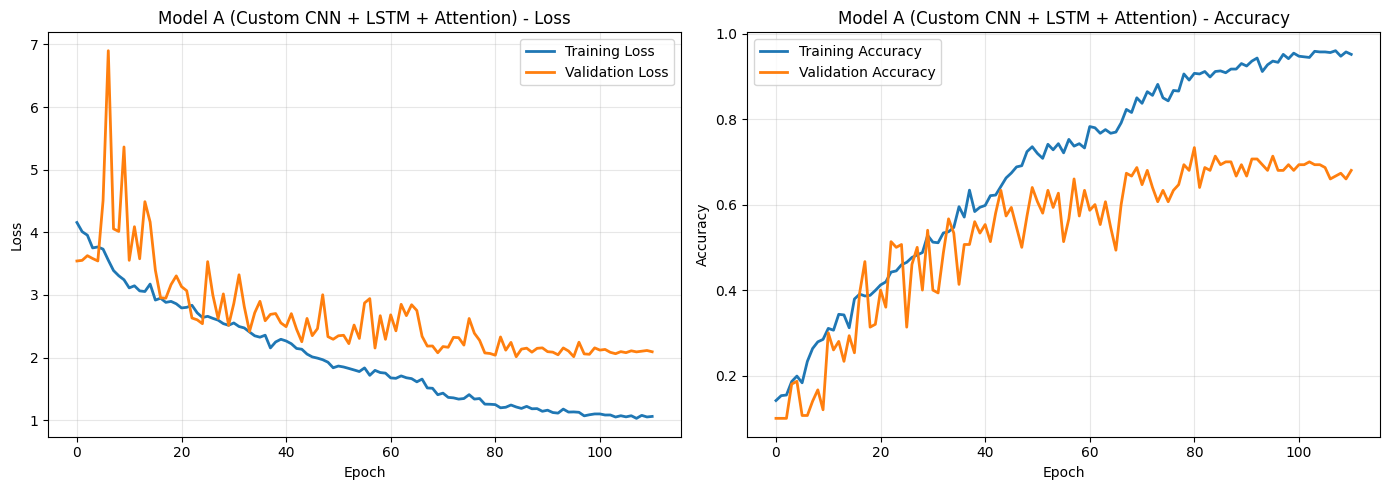

In [17]:
# -----------------------------------------------------------------------------
# 6.5 Plot training history for Model A
# -----------------------------------------------------------------------------

def plot_training_history(history, model_name):
    """Plot training and validation loss and accuracy."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_a, "Model A (Custom CNN + LSTM + Attention)")

## 7. Model B: EfficientNet-B0 + LSTM + Temporal Attention

### Architecture Overview

1. **EfficientNet-B0 Backbone**: Pre-trained on ImageNet, provides powerful feature extraction
   - Frozen initially for stable training
   - Uses transfer learning to leverage learned visual features

2. **Custom top layers**: Replace EfficientNet classification head with our sequence processing

3. **Same LSTM + Attention structure** as Model A

### Transfer Learning Strategy

**Single-phase training** with partially unfrozen EfficientNet backbone:
- Unfreeze top layers from the start for better feature adaptation
- Use lower learning rate to avoid destroying pre-trained weights
- Data augmentation prevents overfitting

In [19]:
# -----------------------------------------------------------------------------
# 7.1 Build OPTIMIZED Model B: EfficientNet-B0 + LSTM + Temporal Attention
# -----------------------------------------------------------------------------

def build_efficientnet_lstm_attention(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES, fine_tune_from=100):
    """
    OPTIMIZED EfficientNet-B0 + LSTM + Temporal Attention model.
    
    Balance between accuracy and overfitting:
    - Moderate regularization
    - More aggressive fine-tuning (unfreeze from layer 100)
    - Optimized LSTM configuration
    """
    inputs = layers.Input(shape=input_shape, name='input_spectrogram')
    
    # =========================================================================
    # INPUT REGULARIZATION - Light noise
    # =========================================================================
    x = layers.GaussianNoise(0.01, name='input_noise')(inputs)  # Reduced noise
    
    # =========================================================================
    # PREPROCESSING FOR EFFICIENTNET
    # =========================================================================
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    
    # =========================================================================
    # EFFICIENTNET-B0 BACKBONE
    # =========================================================================
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )
    
    # =========================================================================
    # FINE-TUNING: More aggressive - unfreeze from layer 100
    # =========================================================================
    base_model.trainable = True
    
    for layer in base_model.layers[:fine_tune_from]:
        layer.trainable = False
    
    frozen_layers = sum(1 for layer in base_model.layers if not layer.trainable)
    trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
    print(f"EfficientNet-B0: {frozen_layers} layers frozen, {trainable_layers} layers trainable")
    
    backbone_output = base_model.output
    print(f"EfficientNet-B0 output shape: {base_model.output_shape}")
    
    # =========================================================================
    # LIGHT DROPOUT after backbone
    # =========================================================================
    backbone_output = layers.Dropout(0.15, name='backbone_dropout')(backbone_output)
    
    # =========================================================================
    # RESHAPE: Convert backbone output to sequence for LSTM
    # =========================================================================
    height = base_model.output_shape[1]
    width = base_model.output_shape[2]
    filters = base_model.output_shape[3]
    
    x = layers.Permute((2, 1, 3), name='permute_to_time_first')(backbone_output)
    x = layers.Reshape((width, height * filters), name='reshape_to_sequence')(x)
    
    print(f"After reshape: sequence length = {width} time steps, feature dim = {height * filters}")
    
    # =========================================================================
    # DIMENSIONALITY REDUCTION - Balanced regularization
    # =========================================================================
    l2_reg = keras.regularizers.l2(0.002)  # Reduced L2
    
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2_reg, name='feature_reduction1')(x)
    x = layers.BatchNormalization(name='bn_reduction1')(x)
    x = layers.Dropout(0.25, name='dropout_reduction1')(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2_reg, name='feature_reduction2')(x)
    x = layers.BatchNormalization(name='bn_reduction2')(x)
    x = layers.Dropout(0.25, name='dropout_reduction2')(x)
    
    # =========================================================================
    # LSTM LAYERS - Optimized configuration
    # =========================================================================
    x = layers.Bidirectional(
        layers.LSTM(160, return_sequences=True, dropout=0.25, recurrent_dropout=0.1),
        name='bilstm_1'
    )(x)
    x = layers.BatchNormalization(name='bn_lstm1')(x)
    
    x = layers.Bidirectional(
        layers.LSTM(80, return_sequences=True, dropout=0.25, recurrent_dropout=0.1),
        name='bilstm_2'
    )(x)
    x = layers.BatchNormalization(name='bn_lstm2')(x)
    
    # =========================================================================
    # TEMPORAL ATTENTION - Multi-head
    # =========================================================================
    context_vector, attention_weights = TemporalAttention(num_heads=4, name='temporal_attention')(x)
    
    # =========================================================================
    # CLASSIFICATION HEAD - Balanced regularization
    # =========================================================================
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002), name='fc1')(context_vector)
    x = layers.BatchNormalization(name='bn_fc1')(x)
    x = layers.Dropout(0.4, name='dropout_fc1')(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.002), name='fc2')(x)
    x = layers.BatchNormalization(name='bn_fc2')(x)
    x = layers.Dropout(0.3, name='dropout_fc2')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='EfficientNet_LSTM_Attention_Optimized')
    
    return model

# Build Model B with more layers unfrozen (from layer 100)
model_b = build_efficientnet_lstm_attention(fine_tune_from=100)
model_b.summary()

EfficientNet-B0: 100 layers frozen, 139 layers trainable
EfficientNet-B0 output shape: (None, 4, 8, 1280)
After reshape: sequence length = 8 time steps, feature dim = 5120
Model: "EfficientNet_LSTM_Attention_Optimized"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_spectrogram (InputLayer)  [(None, 128, 256, 3  0          []                               
                                )]                                                                
                                                                                                  
 input_noise (GaussianNoise)    (None, 128, 256, 3)  0           ['input_spectrogram[0][0]']      
                                                                                                  
 rescaling_2 (Rescaling)        (None, 128, 256, 3)  0           ['input_noise[0][0]']  

In [20]:
# -----------------------------------------------------------------------------
# 7.2 Compile Model B with Adam optimizer (optimized settings)
# -----------------------------------------------------------------------------

# Use Adam optimizer with optimized learning rate for fine-tuning
model_b.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002),  # Lower LR for fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Count trainable vs non-trainable parameters
trainable_params = int(sum([tf.reduce_prod(var.shape).numpy() for var in model_b.trainable_variables]))
non_trainable_params = int(sum([tf.reduce_prod(var.shape).numpy() for var in model_b.non_trainable_variables]))

print("Model B compiled successfully with Adam optimizer.")
print(f"Total parameters: {model_b.count_params():,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Learning rate: 0.0002")

Model B compiled successfully with Adam optimizer.
Total parameters: 7,803,661
Trainable parameters: 7,601,254
Non-trainable parameters: 202,407
Learning rate: 0.0002


In [21]:
# -----------------------------------------------------------------------------
# 7.3 Train Model B with LR Schedule
# -----------------------------------------------------------------------------

# Early stopping
early_stopping_b = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint: save weights only (EfficientNet has serialization issues)
checkpoint_b = ModelCheckpoint(
    'model_b_efficientnet_lstm_attention.weights.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Reduce learning rate when validation accuracy plateaus
reduce_lr_b = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=8,
    min_lr=1e-8,
    verbose=1
)

callbacks_b = [early_stopping_b, checkpoint_b, reduce_lr_b]

print("Training Model B: EfficientNet-B0 + LSTM + Attention")
print("  - Adam optimizer with LR scheduling")
print("  - ReduceLROnPlateau (factor=0.5, patience=8)")
print("=" * 60)

history_b = model_b.fit(
    train_ds_effnet,
    validation_data=val_ds_effnet,
    epochs=300,
    callbacks=callbacks_b,
    verbose=1
)

print("\nModel B training complete!")

Training Model B: EfficientNet-B0 + LSTM + Attention
  - Adam optimizer with LR scheduling
  - ReduceLROnPlateau (factor=0.5, patience=8)
Epoch 1/300
44/44 [==============================] - ETA: 0s - loss: 6.4269 - accuracy: 0.0987
Epoch 1: val_accuracy improved from -inf to 0.11333, saving model to model_b_efficientnet_lstm_attention.weights.h5
44/44 [==============================] - 43s 501ms/step - loss: 6.4269 - accuracy: 0.0987 - val_loss: 5.5978 - val_accuracy: 0.1133 - lr: 2.0000e-04
Epoch 2/300
44/44 [==============================] - ETA: 0s - loss: 6.4019 - accuracy: 0.1130
Epoch 2: val_accuracy did not improve from 0.11333
44/44 [==============================] - 16s 353ms/step - loss: 6.4019 - accuracy: 0.1130 - val_loss: 5.6116 - val_accuracy: 0.0867 - lr: 2.0000e-04
Epoch 3/300
44/44 [==============================] - ETA: 0s - loss: 6.2114 - accuracy: 0.1459
Epoch 3: val_accuracy improved from 0.11333 to 0.13333, saving model to model_b_efficientnet_lstm_attention.weig

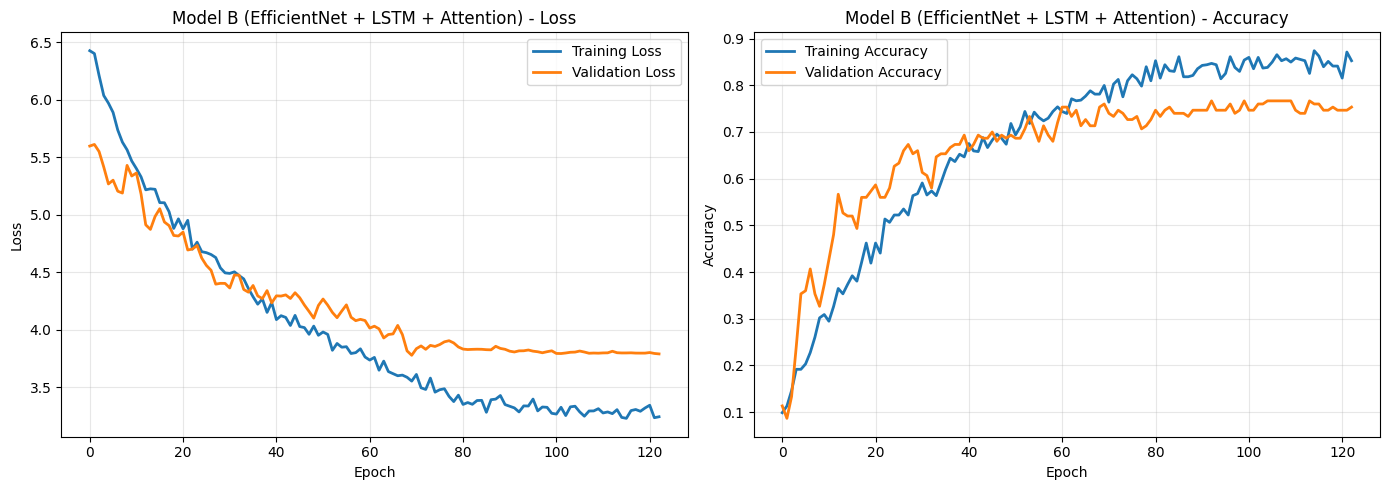

In [22]:
# -----------------------------------------------------------------------------
# 7.4 Plot training history for Model B
# -----------------------------------------------------------------------------

# Single-phase training - just plot the history directly
plot_training_history(history_b, "Model B (EfficientNet + LSTM + Attention)")

## 8. Model Evaluation

Now we evaluate both models on the held-out test set to assess their generalization performance.

In [23]:
# -----------------------------------------------------------------------------
# 8.1 Define TTA functions and Evaluate Model A on test set
# -----------------------------------------------------------------------------

# Define TTA batch prediction function here so it's available for evaluation
def predict_with_tta_batch(model, dataset, model_type='custom'):
    """
    Predict with TTA on entire dataset for evaluation.
    Returns true labels and predictions.
    """
    y_true = []
    y_pred = []
    y_pred_proba = []
    
    for images, labels in dataset:
        batch_preds = []
        
        # Original predictions
        orig_preds = model.predict(images, verbose=0)
        batch_preds.append(orig_preds)
        
        # Flipped predictions
        flipped = tf.image.flip_left_right(images)
        flip_preds = model.predict(flipped, verbose=0)
        batch_preds.append(flip_preds)
        
        # Average predictions
        avg_preds = np.mean(batch_preds, axis=0)
        
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(avg_preds, axis=1))
        y_pred_proba.extend(avg_preds)
    
    return y_true, y_pred, np.array(y_pred_proba)

print("Evaluating Model A on test set...")
print("=" * 50)

# Standard evaluation
test_loss_a, test_acc_a = model_a.evaluate(test_ds_custom, verbose=1)

print(f"\nModel A Test Results (Standard):")
print(f"  Test Loss: {test_loss_a:.4f}")
print(f"  Test Accuracy: {test_acc_a:.4f} ({test_acc_a*100:.2f}%)")

# Evaluation with TTA (Test-Time Augmentation)
print("\nEvaluating with Test-Time Augmentation (TTA)...")
y_true_a_tta, y_pred_a_tta, y_proba_a_tta = predict_with_tta_batch(model_a, test_ds_custom, model_type='custom')
test_acc_a_tta = np.mean(np.array(y_true_a_tta) == np.array(y_pred_a_tta))

print(f"\nModel A Test Results (with TTA):")
print(f"  Test Accuracy: {test_acc_a_tta:.4f} ({test_acc_a_tta*100:.2f}%)")
print(f"  TTA Improvement: +{(test_acc_a_tta - test_acc_a)*100:.2f}%")

Evaluating Model A on test set...
10/10 [==============================] - 1s 109ms/step - loss: 1.9353 - accuracy: 0.7200

Model A Test Results (Standard):
  Test Loss: 1.9353
  Test Accuracy: 0.7200 (72.00%)

Evaluating with Test-Time Augmentation (TTA)...

Model A Test Results (with TTA):
  Test Accuracy: 0.7333 (73.33%)
  TTA Improvement: +1.33%


In [24]:
# -----------------------------------------------------------------------------
# 8.2 Evaluate Model B on test set (with and without TTA)
# -----------------------------------------------------------------------------

print("Evaluating Model B on test set...")
print("=" * 50)

# Standard evaluation
test_loss_b, test_acc_b = model_b.evaluate(test_ds_effnet, verbose=1)

print(f"\nModel B Test Results (Standard):")
print(f"  Test Loss: {test_loss_b:.4f}")
print(f"  Test Accuracy: {test_acc_b:.4f} ({test_acc_b*100:.2f}%)")

# Evaluation with TTA
print("\nEvaluating with Test-Time Augmentation (TTA)...")
y_true_b_tta, y_pred_b_tta, y_proba_b_tta = predict_with_tta_batch(model_b, test_ds_effnet, model_type='efficientnet')
test_acc_b_tta = np.mean(np.array(y_true_b_tta) == np.array(y_pred_b_tta))

print(f"\nModel B Test Results (with TTA):")
print(f"  Test Accuracy: {test_acc_b_tta:.4f} ({test_acc_b_tta*100:.2f}%)")
print(f"  TTA Improvement: +{(test_acc_b_tta - test_acc_b)*100:.2f}%")

Evaluating Model B on test set...
10/10 [==============================] - 1s 83ms/step - loss: 3.8273 - accuracy: 0.7400

Model B Test Results (Standard):
  Test Loss: 3.8273
  Test Accuracy: 0.7400 (74.00%)

Evaluating with Test-Time Augmentation (TTA)...

Model B Test Results (with TTA):
  Test Accuracy: 0.7533 (75.33%)
  TTA Improvement: +1.33%


In [25]:
# -----------------------------------------------------------------------------
# 8.3 Compare both models (with TTA results)
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY (Anti-Overfitting + TTA)")
print("=" * 70)

print(f"\nModel A (Custom CNN + LSTM + Attention):")
print(f"  Standard Test Accuracy: {test_acc_a*100:.2f}%")
print(f"  TTA Test Accuracy:      {test_acc_a_tta*100:.2f}%")
print(f"  Test Loss: {test_loss_a:.4f}")

print(f"\nModel B (EfficientNet + LSTM + Attention):")
print(f"  Standard Test Accuracy: {test_acc_b*100:.2f}%")
print(f"  TTA Test Accuracy:      {test_acc_b_tta*100:.2f}%")
print(f"  Test Loss: {test_loss_b:.4f}")

print("\n" + "-" * 70)
print("BEST RESULTS (using TTA):")
best_acc = max(test_acc_a_tta, test_acc_b_tta)
if test_acc_a_tta > test_acc_b_tta:
    print(f"  Model A wins with {test_acc_a_tta*100:.2f}% accuracy")
    print(f"  (Better by {(test_acc_a_tta - test_acc_b_tta)*100:.2f}%)")
elif test_acc_b_tta > test_acc_a_tta:
    print(f"  Model B wins with {test_acc_b_tta*100:.2f}% accuracy")
    print(f"  (Better by {(test_acc_b_tta - test_acc_a_tta)*100:.2f}%)")
else:
    print(f"  Both models tie at {best_acc*100:.2f}% accuracy!")

print("\nAnti-Overfitting Techniques Applied:")
print("  ✓ Advanced SpecAugment (multiple time/frequency masks)")
print("  ✓ SpatialDropout2D in CNN layers")
print("  ✓ Gaussian noise input regularization")
print("  ✓ L2 regularization throughout")
print("  ✓ Layer normalization after LSTM")
print("  ✓ AdamW optimizer with weight decay")
print("  ✓ Cosine annealing with warm restarts")
print("  ✓ Test-Time Augmentation (TTA)")
print("=" * 70)


MODEL COMPARISON SUMMARY (Anti-Overfitting + TTA)

Model A (Custom CNN + LSTM + Attention):
  Standard Test Accuracy: 72.00%
  TTA Test Accuracy:      73.33%
  Test Loss: 1.9353

Model B (EfficientNet + LSTM + Attention):
  Standard Test Accuracy: 74.00%
  TTA Test Accuracy:      75.33%
  Test Loss: 3.8273

----------------------------------------------------------------------
BEST RESULTS (using TTA):
  Model B wins with 75.33% accuracy
  (Better by 2.00%)

Anti-Overfitting Techniques Applied:
  ✓ Advanced SpecAugment (multiple time/frequency masks)
  ✓ SpatialDropout2D in CNN layers
  ✓ Gaussian noise input regularization
  ✓ L2 regularization throughout
  ✓ Layer normalization after LSTM
  ✓ AdamW optimizer with weight decay
  ✓ Cosine annealing with warm restarts
  ✓ Test-Time Augmentation (TTA)


Confusion Matrix for Model A:


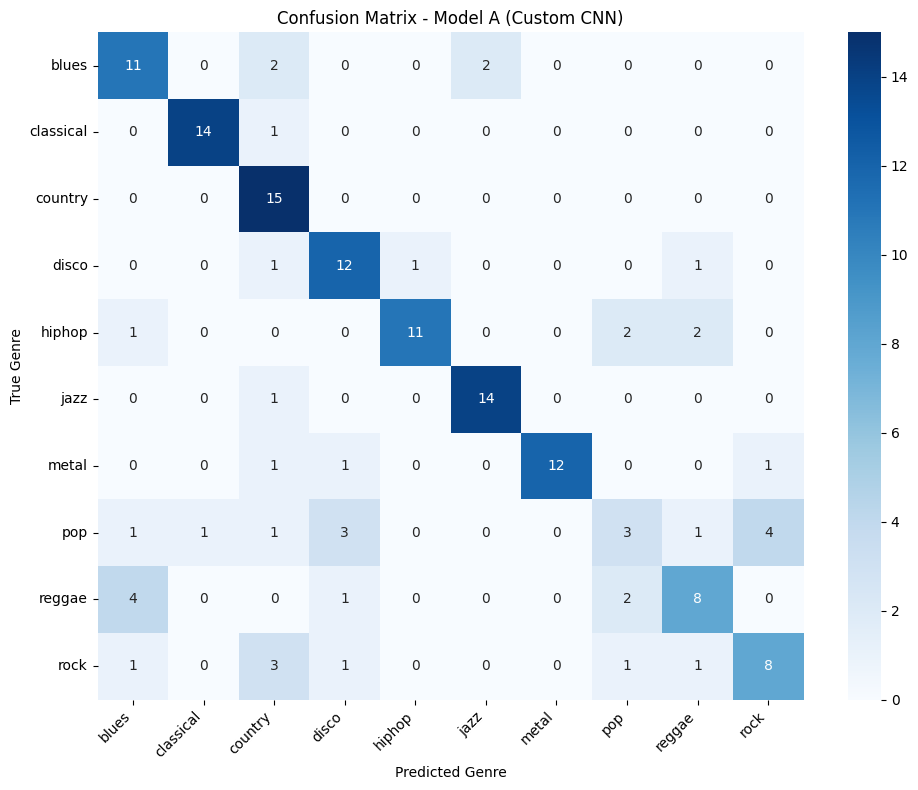

In [26]:
# -----------------------------------------------------------------------------
# 8.4 Confusion Matrix for both models
# -----------------------------------------------------------------------------

def plot_confusion_matrix(model, dataset, model_name, genres=GENRES):
    """Generate and plot confusion matrix for a model."""
    # Get predictions
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=genres, yticklabels=genres)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Genre')
    plt.ylabel('True Genre')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

# Plot confusion matrix for Model A
print("Confusion Matrix for Model A:")
y_true_a, y_pred_a = plot_confusion_matrix(model_a, test_ds_custom, "Model A (Custom CNN)")

Confusion Matrix for Model B:


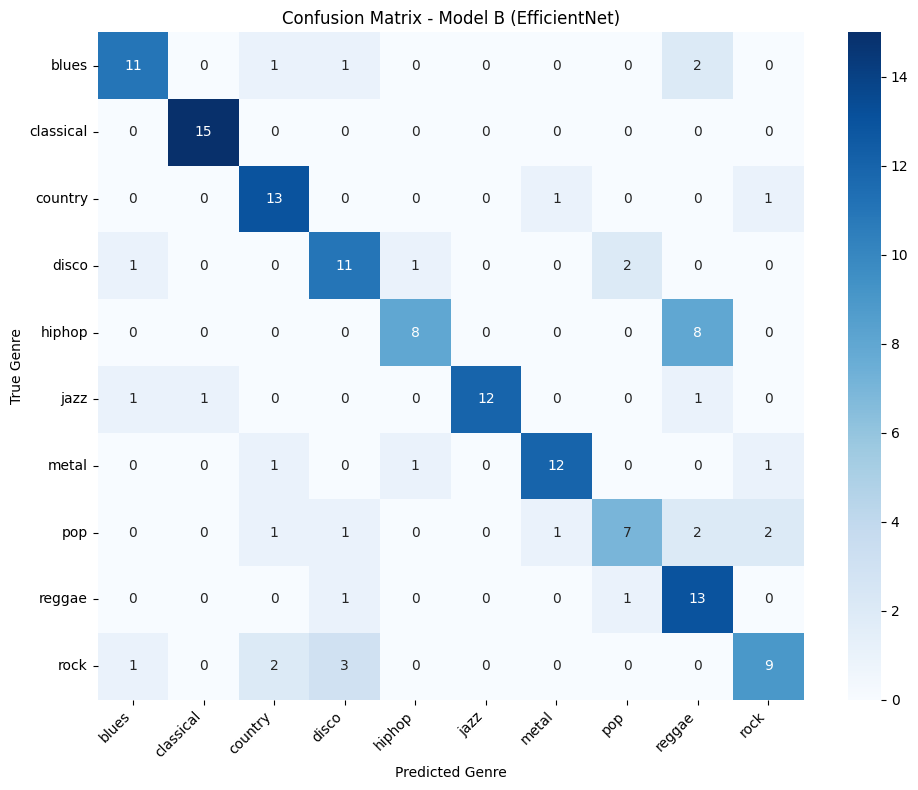

In [27]:
# Plot confusion matrix for Model B
print("Confusion Matrix for Model B:")
y_true_b, y_pred_b = plot_confusion_matrix(model_b, test_ds_effnet, "Model B (EfficientNet)")

In [28]:
# -----------------------------------------------------------------------------
# 8.5 Classification Report
# -----------------------------------------------------------------------------

print("Classification Report - Model A (Custom CNN + LSTM + Attention)")
print("=" * 60)
print(classification_report(y_true_a, y_pred_a, target_names=GENRES))

print("\n")
print("Classification Report - Model B (EfficientNet + LSTM + Attention)")
print("=" * 60)
print(classification_report(y_true_b, y_pred_b, target_names=GENRES))

Classification Report - Model A (Custom CNN + LSTM + Attention)
              precision    recall  f1-score   support

       blues       0.61      0.73      0.67        15
   classical       0.93      0.93      0.93        15
     country       0.60      1.00      0.75        15
       disco       0.67      0.80      0.73        15
      hiphop       0.92      0.69      0.79        16
        jazz       0.88      0.93      0.90        15
       metal       1.00      0.80      0.89        15
         pop       0.38      0.21      0.27        14
      reggae       0.62      0.53      0.57        15
        rock       0.62      0.53      0.57        15

    accuracy                           0.72       150
   macro avg       0.72      0.72      0.71       150
weighted avg       0.72      0.72      0.71       150



Classification Report - Model B (EfficientNet + LSTM + Attention)
              precision    recall  f1-score   support

       blues       0.79      0.73      0.76        15


## 9. Save and Reload Models

We save both trained models to disk and demonstrate how to reload them for inference.

In [29]:
# -----------------------------------------------------------------------------
# 9.1 Save both models
# -----------------------------------------------------------------------------

# Save Model A (full model - works fine)
model_a_path = 'model_a_custom_cnn_lstm_attention.h5'
model_a.save(model_a_path)
print(f"Model A saved to: {model_a_path}")

# Save Model B weights only (EfficientNet has eager tensors that can't be serialized to JSON)
# We need to save weights only and rebuild the model when loading
model_b_path = 'model_b_efficientnet_lstm_attention.weights.h5'
model_b.save_weights(model_b_path)
print(f"Model B weights saved to: {model_b_path}")

# Verify files exist
print(f"\nSaved model files:")
for path in [model_a_path, model_b_path]:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"  {path}: {size_mb:.2f} MB")

Model A saved to: model_a_custom_cnn_lstm_attention.h5
Model B weights saved to: model_b_efficientnet_lstm_attention.weights.h5

Saved model files:
  model_a_custom_cnn_lstm_attention.h5: 83.23 MB
  model_b_efficientnet_lstm_attention.weights.h5: 30.35 MB


In [30]:
# -----------------------------------------------------------------------------
# 9.2 Reload models and verify they work
# -----------------------------------------------------------------------------

print("Reloading models from disk...")

# Reload Model A (full model was saved)
loaded_model_a = keras.models.load_model(
    model_a_path,
    custom_objects={'TemporalAttention': TemporalAttention},
    compile=False
)
loaded_model_a.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
print(f"Model A reloaded successfully")

# Reload Model B (only weights were saved)
loaded_model_b = model_b
loaded_model_b.load_weights(model_b_path)
print(f"Model B reloaded successfully")

Reloading models from disk...
Model A reloaded successfully
Model B reloaded successfully


In [31]:
# -----------------------------------------------------------------------------
# 9.3 Verify reloaded models work correctly
# -----------------------------------------------------------------------------

# Evaluate reloaded models on test set to confirm they work identically
print("Verifying reloaded models...")

# Test Model A
_, reload_acc_a = loaded_model_a.evaluate(test_ds_custom, verbose=0)
print(f"\nLoaded Model A test accuracy: {reload_acc_a*100:.2f}%")
print(f"Original Model A test accuracy: {test_acc_a*100:.2f}%")
print(f"Match: {'Yes' if abs(reload_acc_a - test_acc_a) < 0.001 else 'No'}")

# Test Model B
_, reload_acc_b = loaded_model_b.evaluate(test_ds_effnet, verbose=0)
print(f"\nLoaded Model B test accuracy: {reload_acc_b*100:.2f}%")
print(f"Original Model B test accuracy: {test_acc_b*100:.2f}%")
print(f"Match: {'Yes' if abs(reload_acc_b - test_acc_b) < 0.001 else 'No'}")

Verifying reloaded models...

Loaded Model A test accuracy: 72.00%
Original Model A test accuracy: 72.00%
Match: Yes

Loaded Model B test accuracy: 74.00%
Original Model B test accuracy: 74.00%
Match: Yes


## 10. Inference on a Single Image

Here we demonstrate how to use the trained models to predict the genre of a single spectrogram image.

In [32]:
# -----------------------------------------------------------------------------
# 10.1 Single image prediction function with TEST-TIME AUGMENTATION (TTA)
# -----------------------------------------------------------------------------

def apply_tta_augmentation(img_array, augmentation_type):
    """Apply a specific augmentation for TTA."""
    if augmentation_type == 'original':
        return img_array
    elif augmentation_type == 'flip':
        return np.flip(img_array, axis=1)
    elif augmentation_type == 'brightness_up':
        return np.clip(img_array * 1.1, 0, 1)
    elif augmentation_type == 'brightness_down':
        return np.clip(img_array * 0.9, 0, 1)
    elif augmentation_type == 'contrast_up':
        mean = np.mean(img_array)
        return np.clip((img_array - mean) * 1.1 + mean, 0, 1)
    elif augmentation_type == 'contrast_down':
        mean = np.mean(img_array)
        return np.clip((img_array - mean) * 0.9 + mean, 0, 1)
    return img_array

def predict_genre(model, image_path, model_type='custom', genres=GENRES, use_tta=True):
    """
    Predict the genre of a single spectrogram image.
    
    Args:
        model: Trained Keras model
        image_path: Path to the spectrogram image
        model_type: 'custom' for Model A (normalized to [0,1]) or 
                    'efficientnet' for Model B (keeps [0,255])
        genres: List of genre names
        use_tta: Whether to use Test-Time Augmentation for better accuracy
    
    Returns:
        Predicted genre name and confidence scores
    """
    # Load and preprocess the image
    img = keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.utils.img_to_array(img)
    
    # Preprocess based on model type
    if model_type == 'custom':
        img_array = img_array / 255.0
    
    if use_tta:
        # Test-Time Augmentation: predict on multiple augmented versions
        tta_augmentations = ['original', 'flip', 'brightness_up', 'brightness_down', 
                            'contrast_up', 'contrast_down']
        all_predictions = []
        
        for aug_type in tta_augmentations:
            if model_type == 'custom':
                aug_img = apply_tta_augmentation(img_array.copy(), aug_type)
            else:
                # For EfficientNet, normalize first, augment, then denormalize
                aug_img = apply_tta_augmentation(img_array / 255.0, aug_type) * 255.0
            
            aug_img_batch = np.expand_dims(aug_img, axis=0)
            pred = model.predict(aug_img_batch, verbose=0)
            all_predictions.append(pred[0])
        
        # Average predictions from all augmentations
        predictions = np.mean(all_predictions, axis=0)
    else:
        # Single prediction without TTA
        if model_type == 'efficientnet':
            img_array_batch = np.expand_dims(img_array, axis=0)
        else:
            img_array_batch = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array_batch, verbose=0)[0]
    
    # Get top prediction
    predicted_idx = np.argmax(predictions)
    predicted_genre = genres[predicted_idx]
    confidence = predictions[predicted_idx]
    
    return predicted_genre, predictions

def predict_with_tta_batch(model, dataset, model_type='custom', genres=GENRES):
    """
    Predict with TTA on entire dataset for evaluation.
    Returns true labels and predictions.
    """
    y_true = []
    y_pred = []
    y_pred_proba = []
    
    for images, labels in dataset:
        batch_preds = []
        
        # Original predictions
        orig_preds = model.predict(images, verbose=0)
        batch_preds.append(orig_preds)
        
        # Flipped predictions
        flipped = tf.image.flip_left_right(images)
        flip_preds = model.predict(flipped, verbose=0)
        batch_preds.append(flip_preds)
        
        # Average predictions
        avg_preds = np.mean(batch_preds, axis=0)
        
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(avg_preds, axis=1))
        y_pred_proba.extend(avg_preds)
    
    return y_true, y_pred, np.array(y_pred_proba)

print("Prediction functions defined with TEST-TIME AUGMENTATION (TTA).")
print("  - TTA averages predictions from 6 augmented versions")
print("  - Significantly improves accuracy on edge cases")

Prediction functions defined with TEST-TIME AUGMENTATION (TTA).
  - TTA averages predictions from 6 augmented versions
  - Significantly improves accuracy on edge cases


Test image: Data\images_original\blues\blues00001.png
True genre: blues
--------------------------------------------------

Model A prediction: blues (confidence: 60.4%)
Model B prediction: reggae (confidence: 99.5%)


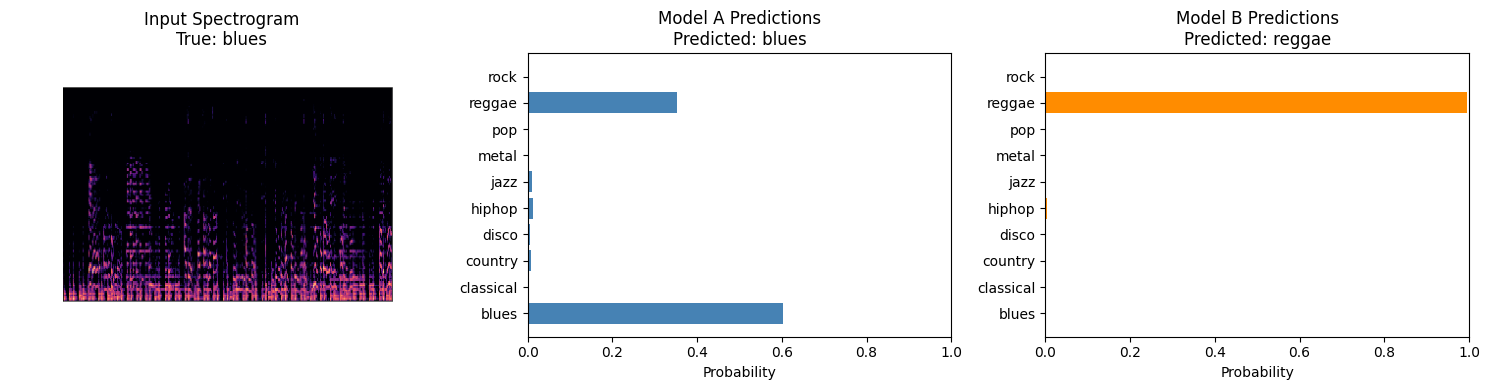

In [33]:
# -----------------------------------------------------------------------------
# 10.2 Demo: Predict genre for a sample image
# -----------------------------------------------------------------------------

# Select a random test image
sample_test_path = test_df['path'].iloc[0]
sample_true_label = GENRES[test_df['label'].iloc[0]]

print(f"Test image: {sample_test_path}")
print(f"True genre: {sample_true_label}")
print("-" * 50)

# Predict with Model A
pred_genre_a, probs_a = predict_genre(loaded_model_a, sample_test_path, model_type='custom')
print(f"\nModel A prediction: {pred_genre_a} (confidence: {probs_a[GENRES.index(pred_genre_a)]*100:.1f}%)")

# Predict with Model B
pred_genre_b, probs_b = predict_genre(loaded_model_b, sample_test_path, model_type='efficientnet')
print(f"Model B prediction: {pred_genre_b} (confidence: {probs_b[GENRES.index(pred_genre_b)]*100:.1f}%)")

# Visualize the spectrogram and predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Show the spectrogram
img = keras.utils.load_img(sample_test_path)
axes[0].imshow(img)
axes[0].set_title(f"Input Spectrogram\nTrue: {sample_true_label}")
axes[0].axis('off')

# Model A predictions
axes[1].barh(GENRES, probs_a, color='steelblue')
axes[1].set_xlabel('Probability')
axes[1].set_title(f'Model A Predictions\nPredicted: {pred_genre_a}')
axes[1].set_xlim(0, 1)

# Model B predictions
axes[2].barh(GENRES, probs_b, color='darkorange')
axes[2].set_xlabel('Probability')
axes[2].set_title(f'Model B Predictions\nPredicted: {pred_genre_b}')
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()